In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx # library containing barabasi_albert network and watts_strogatz (small world) network.
from scipy.sparse import csr_matrix # to convert scipy sparse matrix into numpy-array.
from scipy.integrate import odeint as Int #solve ode
import random

In [39]:
## Import data for 'NY' 

orig_data = pd.read_csv("Data/Kaggle_Covid_19_NY_cleaned.csv",sep = ',')#...Total_Population = S0 = 60461826
orig_data.columns = ['Sl','Date', 'Infected', 'Deaths', 'Recovered']
orig_data.tail(10)

,Sl,Date,Infected,Deaths,Recovered
101,39848,2020-06-11,380892.0,30580.0,0.0
102,40577,2020-06-12,381714.0,30758.0,0.0
103,41306,2020-06-13,382630.0,30795.0,0.0
104,42035,2020-06-14,383324.0,30825.0,0.0
105,42764,2020-06-15,383944.0,30856.0,0.0
106,43493,2020-06-16,384575.0,30909.0,0.0
107,44222,2020-06-17,385142.0,30939.0,0.0
108,44951,2020-06-18,385760.0,30974.0,0.0
109,45680,2020-06-19,386556.0,31015.0,0.0
110,46409,2020-06-20,387272.0,31083.0,0.0


In [47]:
## Some refinements.

data_new = orig_data
ratio_death_recovered = data_new.iloc[-1,3]/data_new.iloc[-1,4]
print("The ratio of Dead to that of Recovered = %0.4f"%ratio_death_recovered)
data_new['Removed'] = data_new['Deaths']+data_new['Recovered']
data_new['Active_cases'] = data_new['Infected']-data_new['Removed']
data = data_new.drop(['Recovered','Deaths'],axis=1)
data.tail(10)

The ratio of Dead to that of Recovered = inf


/home/rodo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


,Sl,Date,Infected,Removed,Active_cases
101,39848,2020-06-11,380892.0,30580.0,350312.0
102,40577,2020-06-12,381714.0,30758.0,350956.0
103,41306,2020-06-13,382630.0,30795.0,351835.0
104,42035,2020-06-14,383324.0,30825.0,352499.0
105,42764,2020-06-15,383944.0,30856.0,353088.0
106,43493,2020-06-16,384575.0,30909.0,353666.0
107,44222,2020-06-17,385142.0,30939.0,354203.0
108,44951,2020-06-18,385760.0,30974.0,354786.0
109,45680,2020-06-19,386556.0,31015.0,355541.0
110,46409,2020-06-20,387272.0,31083.0,356189.0


In [48]:
## Let's scale the data for per 10,000 people.
#NY Population = 8336817
data.loc[:,['Infected','Removed','Active_cases']] = data.loc[:,['Infected','Removed','Active_cases']]*(10000/8336817)
data.head(10)

,Sl,Date,Infected,Removed,Active_cases
0,3071,2020-03-02,0.001199,0.0,0.001199
1,3220,2020-03-03,0.001199,0.0,0.001199
2,3383,2020-03-04,0.001199,0.0,0.001199
3,3492,2020-03-05,0.004798,0.0,0.004798
4,3642,2020-03-06,0.019192,0.0,0.019192
5,3853,2020-03-07,0.013194,0.0,0.013194
6,4084,2020-03-08,0.014394,0.0,0.014394
7,4327,2020-03-09,0.022790,0.0,0.022790
8,4549,2020-03-10,0.207513,0.0,0.207513
9,4755,2020-03-11,0.263890,0.0,0.263890


In [49]:
data.tail(10)

,Sl,Date,Infected,Removed,Active_cases
101,39848,2020-06-11,456.879406,36.680666,420.198740
102,40577,2020-06-12,457.865394,36.894177,420.971217
103,41306,2020-06-13,458.964135,36.938558,422.025576
104,42035,2020-06-14,459.796587,36.974543,422.822043
105,42764,2020-06-15,460.540276,37.011728,423.528548
106,43493,2020-06-16,461.297159,37.075301,424.221858
107,44222,2020-06-17,461.977275,37.111286,424.865989
108,44951,2020-06-18,462.718565,37.153268,425.565297
109,45680,2020-06-19,463.673366,37.202448,426.470918
110,46409,2020-06-20,464.532207,37.284014,427.248193


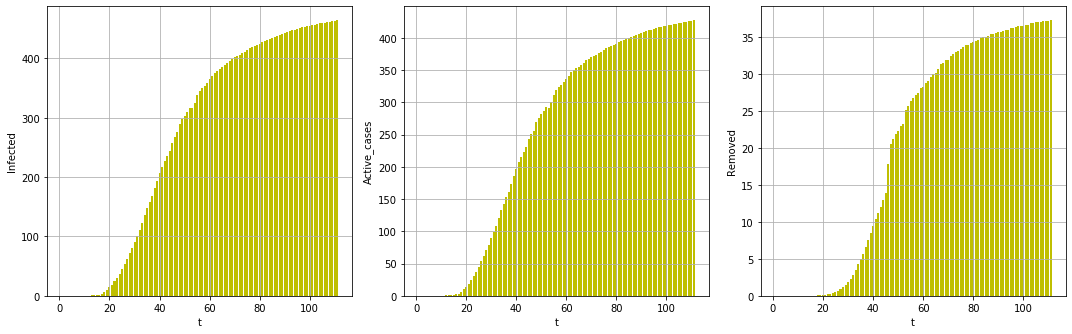

In [50]:
## Lets's see bar plot of data to visualize how data looks like.

figure, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
len_data = len(data)
xx = np.linspace(1,len_data,len_data)
lst = ['Infected','Active_cases','Removed']
for i in range(3):
    y = np.array(data.loc[:,lst[i]])
    axes[i].bar(xx,y,color = 'y')
    axes[i].set_xlabel("t")
    axes[i].set_ylabel(lst[i])
    axes[i].set_title(lst[i])
    axes[i].grid()
figure.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [17]:
def system_ODE(y,t, beta, sigma, gamma):
    # beta controls S to E, sigma= E to I,gamma= I to R.
    s, e, i, r = y
    dydt = [-beta*s*i, beta*s*i-sigma*e, sigma*e-gamma*i, gamma*i]
    return dydt

In [7]:
## Decide which elements of exposed array to keep and which to not.

def decider(exposed_array, prob_array):
    n = len(exposed_array)
    decided_array = []
    for i in range(n):
        #random.seed(i)
        p = random.random()
        if p<=prob_array[i]:
            decided_array.append(exposed_array[i])
        #else: #not required actually
        #    decided_array = decided_array
    return decided_array

In [8]:
## Create removed individuals from infected group.

def I_R(infect_lst,prob):
    removed = []
    for i in infect_lst:
        #random.seed(i)
        p = random.random()
        if p<=prob:
            removed.append(i)
    return removed

In [9]:
## Create a probability array according to the given values of connectivity.

def prob_arr(count_arr,q):# q must be between 0 and 1
    prob_array = []
    for i in count_arr:
        p = 1-(1-q)**i# q-influence model where we take probability of getting infected is more if infected individuals are more.
        prob_array.append(p)
    return np.array(prob_array)

In [10]:
## Remove elements in from_list which are in lst.

def remover(from_listorarray,lst):# elements in lst are to be removed from from_list
    for i in lst:
        from_listorarray = [x for x in from_listorarray if x!=i]
    return from_listorarray

In [11]:
def Networked_Barabasi_SEIR(A,sigma,gamma):
    dim = len(A)
    N = [i for i in range(1,dim+1)]# index of individuals
    E = []
    I = [random.choice(N)]
    #for l in I: #calculating initial no. of exposed.
    #    arr1 = A[l,:]
    #    arr1 = np.nonzero(arr1)[0]+1
    #    arr1 = np.squeeze(arr1).tolist()
    #    E.extend(arr1)
    #E_actual = np.unique(E).tolist()
    tot = E+I
    S = remover(N,tot)# as at any time S+E+I+R = N. So at time = 0, S+I=N
    R = []
    I_old = []
    s = len(S)
    e = len(E)
    i = len(I)
    r = len(R)
    SEIR  = np.array([[s],[e],[i],[r]])
    time = 0
    #for z in range(time):
    #    vec1 = np.array([[s],[e],[i],[r]])
    #    SEIR = np.concatenate((SEIR,vec1),axis=1)
    while i >0:#i.e. when i becomes 0 stop

        #Cal no. of infected
        #print('\nTime = ',time)
        if e!=0:
            exp_arr, count_arr = np.unique(E, return_counts=True)
            prob_array = prob_arr(count_arr,sigma)#q= 0.5 - 0.85
            infect_list = decider(exp_arr,prob_array)
            I.extend(infect_list)
            E = remover(E,I)#excluding all infected from exposed
        #print('Ifirst = ',I)
        #Cal no. of removed

        removed = I_R(I,gamma)
        I = remover(I,removed)
        R.extend(removed)
        r = len(R)
        #print("recovered = ",R)

        i = len(I)
        #print("Infect = ",I)
        
        # Cal no. of exposed
        #print('I_old value = ',I_old)
        I1 = remover(I,I_old)# this is done as we want to cal the exposed to new infected, not the old ones.
        #print('I1= ',I1)
        I1 = (np.array(I1)-1).tolist()# this is done to revert to original indexing.
        to_rem_lst = I+R
        for j in I1:
            arr = A[j,:]
            arr = np.nonzero(arr)[0]+1# gives position
            #print('arr -value = ',arr)
            arr = remover(arr,to_rem_lst)
            E.extend(arr)
        E_actual = np.unique(E).tolist()
        e = len(E_actual)
        #print("Exposed = ",E)

        #Cal value of S

        tot_not_sus = E_actual+I+R
        S = remover(N,tot_not_sus)
        s = len(S)

        #print("suscep = ",S)
        
        #Store old value of Infected
        I_old = np.array(I)
        #print('I_old_again = ',type(I_old))
        
        #print("I_old = ",I_old)
        

        vec = np.array([[s],[e],[i],[r]])
        SEIR = np.concatenate((SEIR,vec),axis=1)
        
        time += 1

    return SEIR, time+1

In [100]:
## create Barabasi_albert model

n = int(input("Enter the number of nodes(individuals) of human society = "))#no. of nodes = population
m = int(input("Enter the number of edges you want to join each time while forming network = "))#no. of edges we want 
G = nx.barabasi_albert_graph(n,m) #required humanity_interaction graph through Barabasi model. 
#nx.draw(G, with_labels = True)
#plt.show()

## Note : More 'm' means network with more edges i.e. network with more human interaction

Enter the number of nodes(individuals) of human society = 10000
Enter the number of edges you want to join each time while forming network = 25


In [101]:
## Adjacency matrix.

A = nx.adjacency_matrix(G)
A = csr_matrix(A).toarray()
#A.todense()
#A.setdiag(A.diagonal()*2)
#print(A.todense())

In [104]:
## Let's see the interaction and disease spread.
sigma = 0.5
gamma = 0.2
SEIR, time = Networked_Barabasi_SEIR(A,sigma,gamma)


Total number of time steps =  49


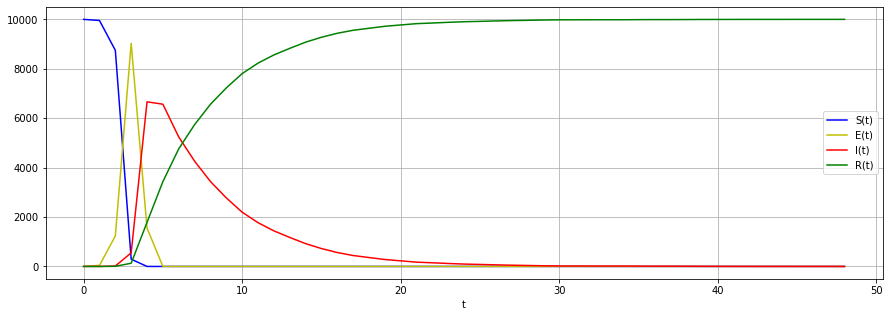

In [105]:
T = [k for k in range(time)]
print("Total number of time steps = ",time)
plt.figure(figsize=(15,5))
plt.plot(T,SEIR[0,:],color = 'b',label = 'S(t)')
plt.plot(T,SEIR[1,:],color = 'y',label = 'E(t)')
plt.plot(T,SEIR[2,:],color = 'r',label = 'I(t)')
plt.plot(T,SEIR[3,:],color = 'g',label = 'R(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [106]:
## let's compute beta
avg_degree = np.sum(A)/n
beta = avg_degree/n#n = no. of total nodes
params = (beta,sigma,gamma)
y0 = [9999,0,1,0]
t = np.linspace(0,time,time)
soln = Int(system_ODE,y0,t,args=params)

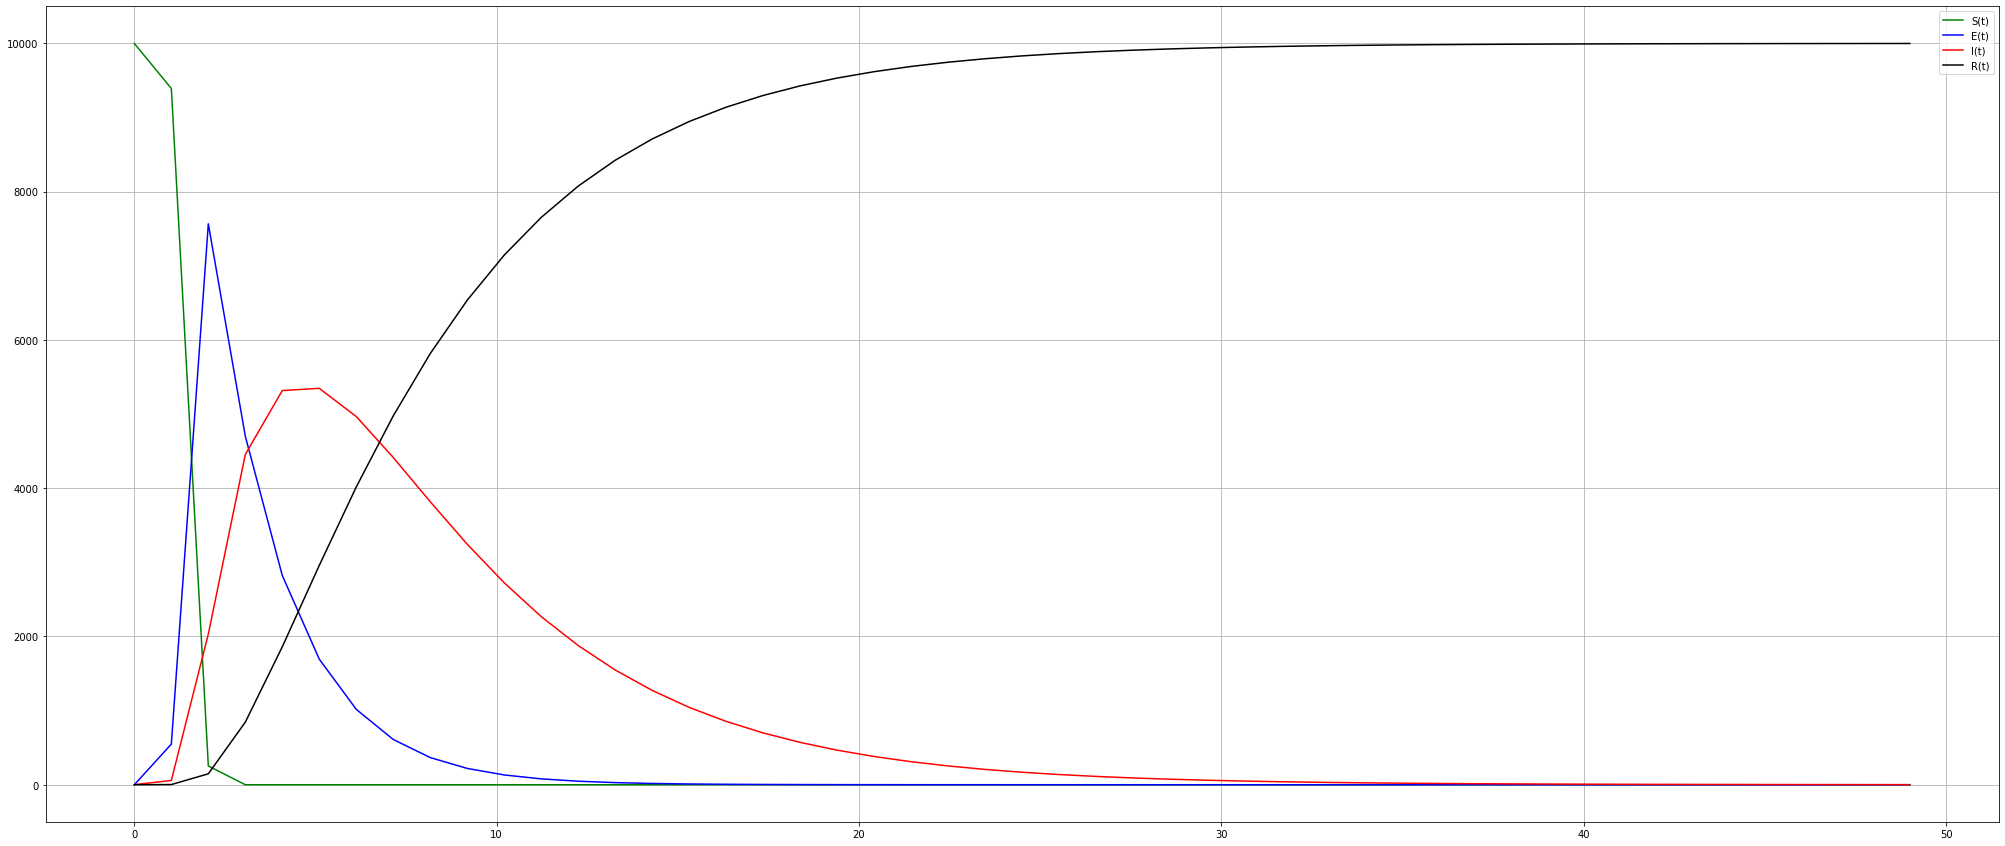

In [107]:
## Plot solution from ODE...

plt.figure(figsize=(35,15))

plt.plot(t,soln[:,0],'g',label = 'S(t)')
plt.plot(t,soln[:,1],'b',label = 'E(t)')
plt.plot(t,soln[:,2],'r',label = 'I(t)')
plt.plot(t,soln[:,3],'k',label = 'R(t)')
#plt.bar(t,bar_p,color = 'c')
#plt.bar(t,bar_p1,color = 'y')
#plt.ylim(0,15000)
#plt.ylim(0,300000)
plt.legend(loc='best')
plt.grid()
plt.show()

In [108]:
## Save the SEIR value...in txt file.
np.savetxt("SEIR_"+str(n)+"_"+str(m)+"_"+str(sigma)+"_"+str(gamma)+".txt",SEIR,delimiter = ',')

## ROUGH WORK

In [114]:
tt = np.array([[[1,2],[1,3]],[[1,23],[1,24]]])
tt[0,:,0]

array([1, 1])